In [249]:
%matplotlib inline

from IPython.core.display import display, HTML
from IPython.core.magic import register_cell_magic, register_line_cell_magic, register_line_magic
import pandas as pd
from pyspark.sql.types import DoubleType, IntegerType, StringType, Row
from pyspark.sql.functions import sum, col, udf
import seaborn as sns

from matplotlib import pyplot as plt

In [251]:
# Set default cell width
display(HTML('<style>.container {width:80% !important;}</style>'))

# Set default matplotlib settings
plt.style.use('fivethirtyeight')

plt.rcParams['figure.figsize'] = (16, 7)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['figure.titlesize'] = 24

# mpl.rcParams['lines.linewidth'] = 3
# mpl.rcParams['figure.titlesize'] = 26
# mpl.rcParams['axes.labelsize'] = 18
# mpl.rcParams['axes.titlesize'] = 22
# mpl.rcParams['xtick.labelsize'] = 14
# mpl.rcParams['ytick.labelsize'] = 14
# mpl.rcParams['legend.fontsize'] = 16

# Set seaborn colours
# blue, green, red, purple, yellow, cyan = sns.color_palette()

In [84]:
df = spark.read.option('header','true').csv('data/season_totals.csv')

In [85]:
dtype_dict = {'player' : StringType, 'pos' : StringType, 'team_id' : StringType, 'age' : IntegerType, 'g' : IntegerType, 'gs' : IntegerType, 'yr' : IntegerType}
df2 = df.fillna('0')

for c in df.schema.names[:]:
    dtype = DoubleType if c not in dtype_dict.keys() else dtype_dict[c]
    df2 = df2.withColumn(c,df2[c].cast(dtype()))

* _c0
* player
* pos
* age
* team_id
* g
* gs
* mp
* fg
* fga
* fg_pct
* fg3
* fg3a
* fg3_pct
* fg2
* fg2a
* fg2_pct
* efg_pct
* ft
* fta
* ft_pct
* orb
* drb
* trb
* ast
* stl
* blk
* tov
* pf
* pts
* yr

# View 3 pointers over time

In [155]:
# 3 pointers per minute
# cross check work
sqlContext.registerDataFrameAsTable(df2, 'df2')
df3 = sqlContext.sql('''SELECT yr,
                               sum(fg3a)/sum(mp) fg3a_pm
                        FROM df2 GROUP BY yr
                        ORDER BY yr''')

In [165]:
# 3 point attempts / minute
fga_py = df2.groupBy('yr')\
         .agg({'mp' : 'sum', 'fg3a' : 'sum', 'fga' : 'sum'})\
         .select(col('yr'), (col('sum(fga)')/col('sum(mp)')).alias('fga_pm'), (col('sum(fg3a)')/col('sum(mp)')).alias('fg3a_pm'))\
         .orderBy('yr')\
         .toPandas()

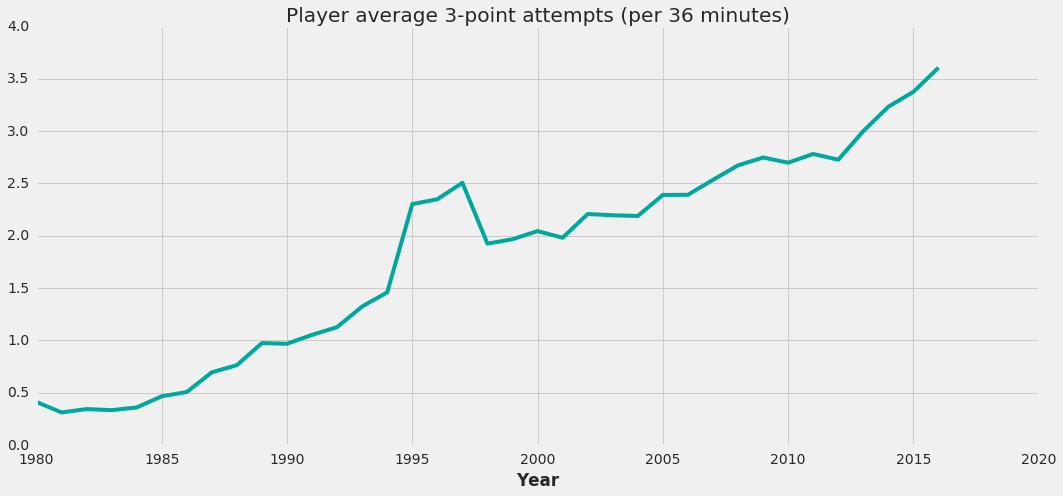

In [190]:
plt.plot(fga_py.yr,36*fga_py.fg3a_pm, color = '#00a79c')
plt.xlabel('Year')
_=plt.title('Player average 3-point attempts (per 36 minutes)')
# plt.plot(36*fga_py.fga_pm)

# Top 10 players each season

In [273]:
sqlContext.registerDataFrameAsTable(df2, 'df2')
df_top10 = sqlContext.sql('''
SELECT * 
FROM
(SELECT *,dense_rank() OVER (PARTITION BY yr order by pts DESC) AS rank
FROM df2) foo
WHERE rank <= 10
ORDER BY yr
''')
sqlContext.registerDataFrameAsTable(df_top10,'df_top10')

In [258]:
a = df_top10.filter('yr == 2016').toPandas()
import numpy as np
np.mean(a.fg3a/a.mp)*36

6.663779341479998

In [247]:
fga_py = df_top10.groupBy('yr')\
         .agg({'mp' : 'sum', 'fg3a' : 'sum', 'fga' : 'sum'})\
         .select(col('yr'), (col('sum(fga)')/col('sum(mp)')).alias('fga_pm'), (col('sum(fg3a)')/col('sum(mp)')).alias('fg3a_pm'))\
         .orderBy('yr')\
         .toPandas()
fga_py

,yr,fga_pm,fg3a_pm
0,1980,0.530313,0.007664
1,1981,0.511784,0.004514
2,1982,0.527746,0.006016
3,1983,0.525162,0.016981
4,1984,0.540137,0.007915
5,1985,0.553374,0.019734
6,1986,0.531054,0.012116
7,1987,0.536929,0.032762
8,1988,0.552888,0.036168
9,1989,0.532291,0.033345


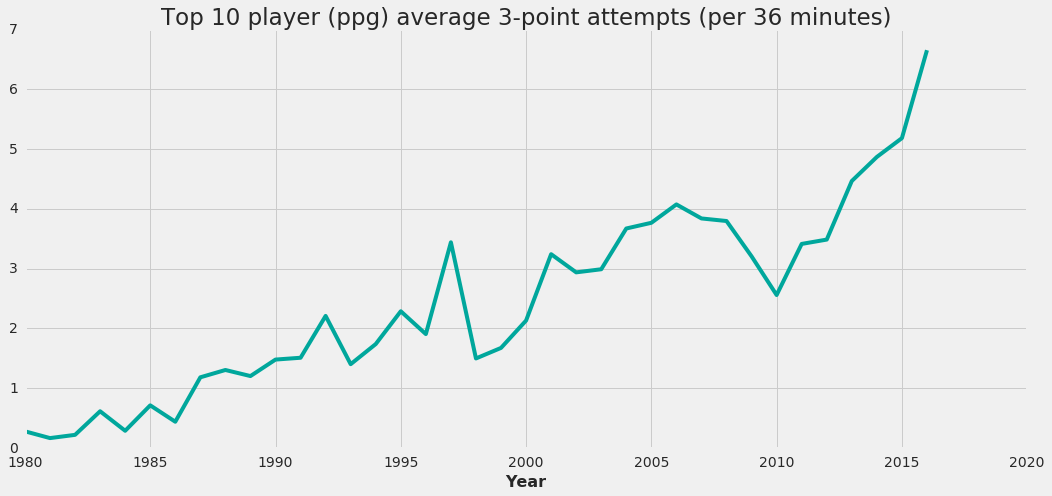

In [260]:
plt.plot(fga_py.yr,36*fga_py.fg3a_pm, color = '#00a79c')
plt.xlabel('Year')
_=plt.title('Top 10 player (ppg) average 3-point attempts (per 36 minutes)')

In [301]:
df2.filter('yr >= 2011').select('fga').agg({'fga':'sum'}).take(1)

[Row(sum(fga)=1292386.0)]

# True shooting percentage

In [288]:
def calc_ts_per(row):
    pts,fga,fta = row.PTS,row.FGA,row.FTA
    return pts/(2*(fga + (0.44*fta)))

df_ts = sqlContext.sql('''
SELECT yr, SUM(pts)/(2 * (SUM(fga) + (.44 * SUM(fta)))) as ts_per
FROM df2
GROUP BY yr
ORDER BY yr
''').toPandas()

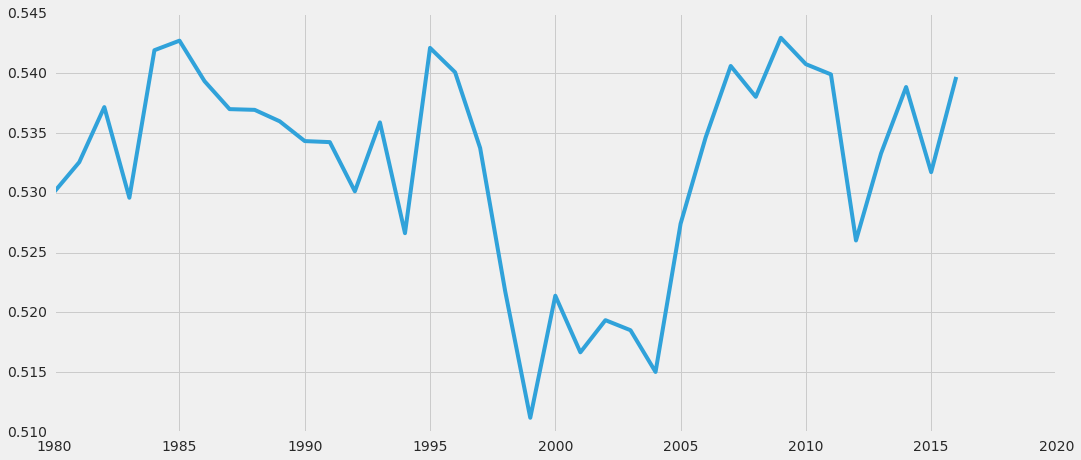

In [289]:
plt.plot(df_ts.yr, df_ts.ts_per)

In [291]:
def calc_ts_per(pts,fga,fta):
    return pts/(2*(fga + (0.44*fta)))

pstats = df2.filter('yr < 2010 and mp > 500').toPandas()
pstats['ts'] = calc_ts_per(pstats.pts,pstats.fga,pstats.fta)

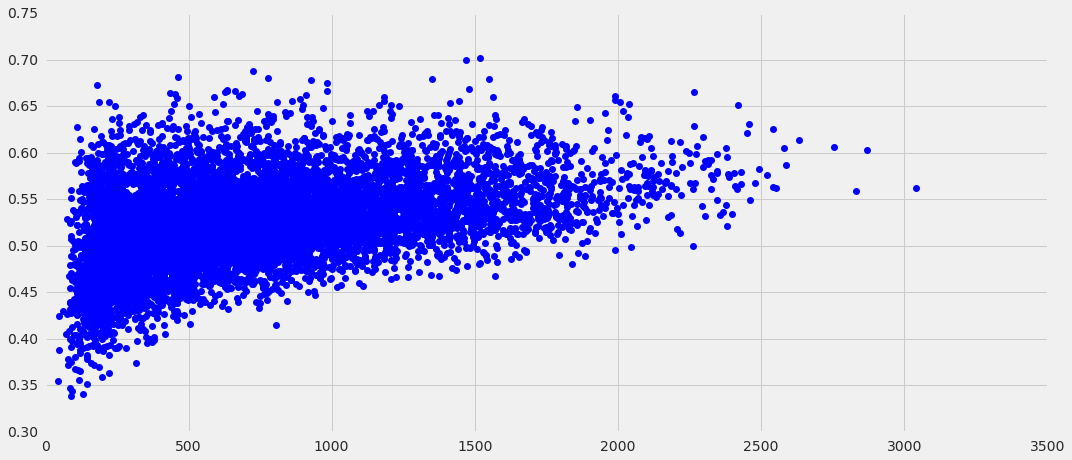

In [292]:
plt.plot(pstats.pts, pstats.ts, 'bo')

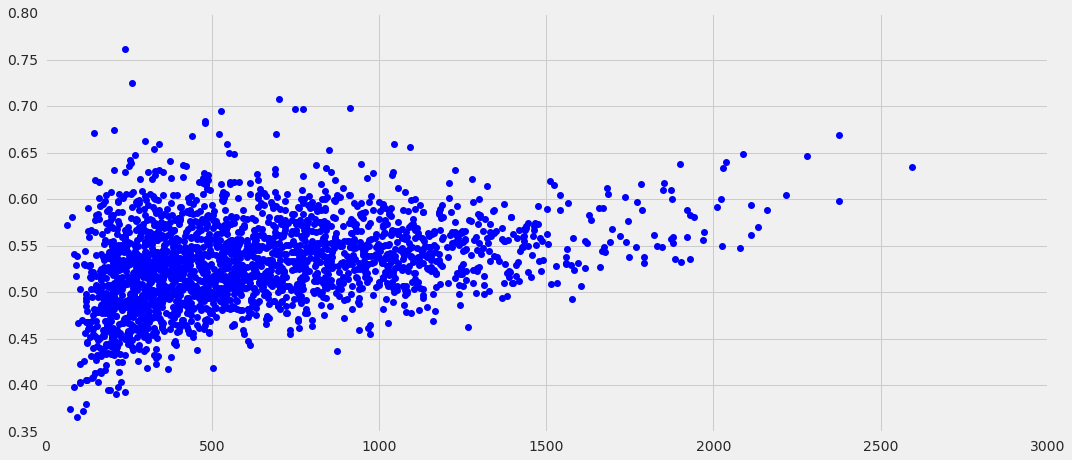

In [290]:
plt.plot(pstats.pts, pstats.ts, 'bo')

In [209]:
@register_cell_magic
def spark_sql(line, cell):
    """
    Show the SQL query that will be run.
    """
    df1,df2 = line.split(' ')
    print df1
    sqlContext.registerDataFrameAsTable(df1, '{}'.format(df1))
    print cell